In [1]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import pandas as pd
import json

In [3]:
df = pd.DataFrame({
    'cups_of_coffee': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'productivity': [2, 5, 6, 8, 9, 8, 0, 1, 0, -1]
})

In [4]:
df = pd.read_csv('sessions_for_intervention.csv')

/home/geza/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


/home/geza/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: refitting model(s) with ML (instead of REML)

  warnings.warn(x, RRuntimeWarning)


Data: ndata
Models:
resultsnull: duration ~ (1 | user) + (1 | goal)
results: duration ~ frequent + (1 | user) + (1 | goal)
            Df    AIC    BIC logLik deviance  Chisq Chi Df Pr(>Chisq)   
resultsnull  4 109505 109539 -54749   109497                            
results      5 109499 109541 -54744   109489 8.6452      1   0.003279 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [42]:
all_intervention_info_list = json.load(open('mobile_intervention_info_list.json'))
intervention_name_to_info = {intervention_info['shortname']: intervention_info for intervention_info in all_intervention_info_list}

def is_target_app(intervention_name):
  intervention_info = intervention_name_to_info[intervention_name]
  return intervention_info['target'] == 'app'

def get_intervention_names(intervention_json):
  intervention_info_list = json.loads(intervention_json.replace("'", '"'))
  intervention_name_list = [x['intervention'] for x in intervention_info_list]
  intervention_name_list = [x for x in intervention_name_list if is_target_app(x)]
  return intervention_name_list

def get_intervention_name(intervention_json):
  intervention_name_list = get_intervention_names(intervention_json)
  if len(intervention_name_list) == 0:
    return ''
  if len(intervention_name_list) == 1:
    return intervention_name_list[0]
  raise ValueError('have multiple target app interventions: ' + intervention_json)


In [50]:
def is_valid_row(intervention_json):
  intervention_info_list = json.loads(intervention_json.replace("'", '"'))
  intervention_name_list = [x['intervention'] for x in intervention_info_list]
  for intervention_name in intervention_name_list:
    if intervention_name not in intervention_name_to_info:
      return False
  return True


df['is_valid_row'] = df['interventions'].map(is_valid_row)
df = df[df.is_valid_row == True].copy()

/home/geza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [29]:
#print(df)

In [51]:
df['first_intervention'] = df['interventions'].map(get_intervention_name)

In [52]:
df['num_interventions'] = df['interventions'].map(lambda x: len(json.loads(x.replace("'", '"'))))

In [55]:
df['duration'] = df['duration (log(s))']
ndata = df

In [ ]:
%%R -i ndata -w 5 -h 5 --units in -r 200

#install.packages('ez')
#install.packages('lme4')

library(lme4)
#library(ez)

In [57]:
%%R -i ndata -w 5 -h 5 --units in -r 200

# SIGNIFCANT: does the frequency have an effect on duration, controlling for user and goal?

results <- lmer(duration ~ frequent + (1|user) + (1|goal), data = ndata)

resultsnull <- lmer(duration ~ (1|user) + (1|goal), data = ndata)

show(anova(resultsnull, results))


Data: ndata
Models:
resultsnull: duration ~ (1 | user) + (1 | goal)
results: duration ~ frequent + (1 | user) + (1 | goal)
            Df    AIC    BIC logLik deviance  Chisq Chi Df Pr(>Chisq)   
resultsnull  4 109346 109380 -54669   109338                            
results      5 109340 109382 -54665   109330 8.6415      1   0.003286 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [56]:
%%R -i ndata -w 5 -h 5 --units in -r 200

# SIGNIFCANT: does the intervention have an effect on duration, controlling for user and goal and frequency?

results <- lmer(duration ~ first_intervention + frequent + (1|user) + (1|goal), data = ndata)

resultsnull <- lmer(duration ~ frequent + (1|user) + (1|goal), data = ndata)

show(anova(resultsnull, results))


/home/geza/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/home/geza/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: refitting model(s) with ML (instead of REML)

  warnings.warn(x, RRuntimeWarning)


Data: ndata
Models:
resultsnull: duration ~ frequent + (1 | user) + (1 | goal)
results: duration ~ first_intervention + frequent + (1 | user) + (1 | 
results:     goal)
            Df    AIC    BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
resultsnull  5 109340 109382 -54665   109330                             
results     19 109225 109386 -54594   109187 142.43     14  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Data: ndata
Models:
resultsnull: duration ~ (1 | user) + (1 | goal)
results: duration ~ frequent + (1 | user) + (1 | goal)
            Df    AIC    BIC logLik deviance  Chisq Chi Df Pr(>Chisq)   
resultsnull  4 109505 109539 -54749   109497                            
results      5 109499 109541 -54744   109489 8.6452      1   0.003279 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [8]:
print(df['num_interventions'].describe())

count    34598.000000
mean         0.612492
std          0.541795
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: num_interventions, dtype: float64


In [24]:
df[df['num_interventions'] == 0].count()

frequent             5303
duration (log(s))    5303
interventions        5303
user                 5303
goal                 5303
num_interventions    5303
dtype: int64

In [23]:
df[df['num_interventions'] == 1].count()

frequent             7911
duration (log(s))    7911
interventions        7911
user                 7911
goal                 7911
num_interventions    7911
dtype: int64

In [25]:
df[df['num_interventions'] == 2].count()

frequent             282
duration (log(s))    282
interventions        282
user                 282
goal                 282
num_interventions    282
dtype: int64

In [26]:
df[df['num_interventions'] == 3].count()

frequent             17
duration (log(s))    17
interventions        17
user                 17
goal                 17
num_interventions    17
dtype: int64

In [27]:
df[df['num_interventions'] == 4].count()

frequent             2
duration (log(s))    2
interventions        2
user                 2
goal                 2
num_interventions    2
dtype: int64

In [19]:
%%R -i df -w 5 -h 5 --units in -r 200

summary(df)

/home/geza/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


  frequent       duration..log.s.. interventions          user          
 Mode :logical   Min.   : 1.792    Length:13515       Length:13515      
 FALSE:6763      1st Qu.: 2.708    Class :character   Class :character  
 TRUE :6752      Median : 3.664    Mode  :character   Mode  :character  
                 Mean   : 3.769                                         
                 3rd Qu.: 4.663                                         
                 Max.   :11.001                                         
     goal           num_interventions
 Length:13515       Min.   :0.0000   
 Class :character   1st Qu.:0.0000   
 Mode  :character   Median :1.0000   
                    Mean   :0.6314   
                    3rd Qu.:1.0000   
                    Max.   :4.0000   


/home/geza/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


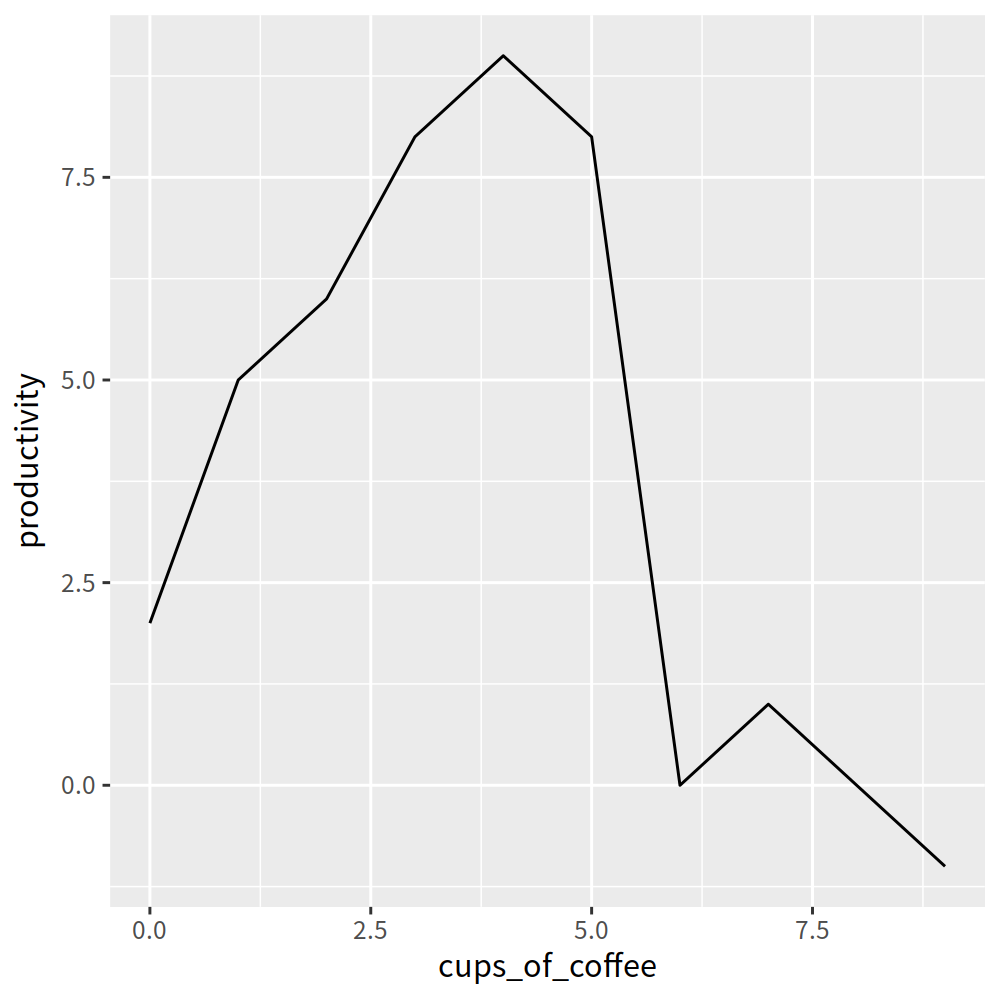

In [6]:
%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

#install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
ggplot(df, aes(x=cups_of_coffee, y=productivity)) + geom_line()